# DCGAN - Non-Saturating GAN
NSGAN指的是通过 $-\log(D(x))$，即直接反转正负样本方式的GAN

# Import Necessary Packages
有一说一这个DCGAN真的太难训练了啊
我使用的Trick
- ONE-SIDE Soft label
- 数据的均值和标准差不能用实际的值，而是要用0.5 why？
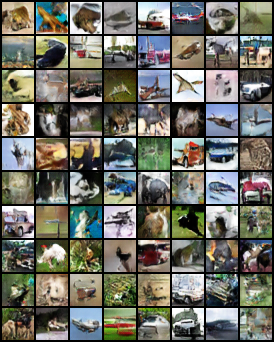


In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4"
import random

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn

import torchvision
from torchvision import datasets
from torchvision import transforms # 张量变换
from torchvision.utils import save_image # 保存图片

import numpy as np

from itertools import product # draw 10 * 10 images
from tqdm import tqdm

import matplotlib.pyplot as plt
# Enable Jupyter notebook plotting
%matplotlib inline

# Pytorch Version
print(torch.__version__)
print(torch.cuda.is_available())

1.7.0
True


# Hyper Parameters

In [2]:
cudnn.benchmark = True

#set manual seed to a constant get a consistent output
manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

batch_size = 128
num_epoch = 100
softlabel = 0.2 # 不要超过0.5！

ngf = 64  # base dimesion of G's feature
ndf = 64 # base dimesion of D's feature
z_dim = 100 # size of input noise's channel

nc = 3 # channels of output images

lr_G = 2e-4
lr_D = 2e-4 # leanring rate of Generator and Discriminator


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Random Seed:  450
cuda:0


# Datasets files & utils

In [3]:
# the path we save data
if not os.path.exists('../../img'):
    os.mkdir('../../img')

# Transform of our datasets
trans = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                       ])
    
# CIFAR10 datasets downloading……
cifar10 = datasets.CIFAR10(
    root = '../../data/cifar10/', train = True, transform = trans, download = True
)

# Dataloader
dataloader = torch.utils.data.DataLoader(
    dataset = cifar10, batch_size = batch_size, shuffle = True, num_workers = 8,
)



Files already downloaded and verified


In [4]:
inv_normalize = transforms.Normalize(
    mean=[-0.5/0.5, -0.5/0.5, -0.5/0.5],
    std=[1/0.5, 1/0.5, 1/0.5]
)
# inv_tensor = inv_normalize(tensor)



# Discriminator Definitions (Vanilla DCGAN Fashion)
As mentioned, the discriminator, $D$, is a binary classification network that takes an image as input and outputs a scalar probability that the input image is real (as opposed to fake).

Here, $D$ takes a 3x64x64 input image, processes it through a series of Conv2d, BatchNorm2d, and LeakyReLU layers, and outputs the final probability through a Sigmoid activation function. 

This architecture can be extended with more layers if necessary for the problem, but there is significance to the use of the strided convolution, BatchNorm, and LeakyReLUs. 
The DCGAN paper mentions it is a good practice to use strided convolution rather than pooling to downsample because it lets the network learn its own pooling function. Also batch norm and leaky relu functions promote healthy gradient flow which is critical for the learning process of both $G$ and $D$.

It is a **unconditional** version.

In [5]:

class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        self.D = nn.Sequential(
            # input is (nc) x 32 x 32
            nn.Conv2d(nc, ndf, kernel_size = 4,
                      stride = 2, padding = 1),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 18
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.D(x)
        return x

# Generator Definitions (Vanilla DCGAN Fashion)
The generator, $G$, is designed to map the latent space vector $(z)$ to data-space. Since our data are images, converting z to data-space means ultimately creating a RGB image with the same size as the training images (i.e. 3x64x64). In practice, this is accomplished through a series of strided two dimensional convolutional transpose layers, each paired with a 2d batch norm layer and a relu activation. The output of the generator is fed through a tanh function to return it to the input data range of $[−1,1]$. It is worth noting the existence of the batch norm functions after the conv-transpose layers, as this is a critical contribution of the DCGAN paper. These layers help with the flow of gradients during training. An image of the generator from the DCGAN paper is shown below.

The generator, G, is designed to map the latent space vector $(z)$ to data-space. Since our data are images, converting z to data-space means ultimately creating a RGB image with the same size as the training images (i.e. 3x64x64). In practice, this is accomplished through a series of strided two dimensional convolutional transpose layers, each paired with a 2d batch norm layer and a relu activation. The output of the generator is fed through a tanh function to return it to the input data range of $[−1,1]$. It is worth noting the existence of the batch norm functions after the conv-transpose layers, as this is a critical contribution of the DCGAN paper. These layers help with the flow of gradients during training. An image of the generator from the DCGAN paper is shown below.

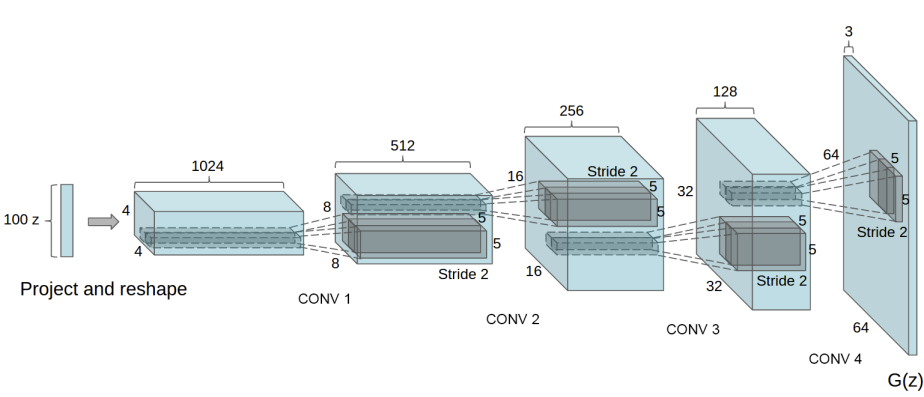

The final `Tanh` activataion function can project output into (-1,1)

Notice, the how the inputs we set in the input section (nz, ngf, and nc) influence the generator architecture in code. nz is the length of the z input vector, ngf relates to the size of the feature maps that are propagated through the generator, and nc is the number of channels in the output image (set to 3 for RGB images). Below is the code for the generator.


It is a **unconditional** version.

In [6]:

class generator(nn.Module):
    
    def __init__(self):
        super(generator, self).__init__()
        self.G = nn.Sequential(
            nn.ConvTranspose2d(z_dim, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            
            nn.ConvTranspose2d(ngf * 8, ngf * 4, kernel_size=4,
                              stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            
            nn.ConvTranspose2d(ngf * 4, ngf * 2, kernel_size=4,
                              stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, nc, kernel_size=4,
                              stride=2, padding=1, bias=False),
            # state size. nc x 32 x 32            
            nn.Tanh()
            )
        
    def forward(self, x):
        x = self.G(x)
        return x
        
        

## Weight Initialization
From the DCGAN paper, the authors specify that all model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02. The weights_init function takes an initialized model as input and reinitializes all convolutional, convolutional-transpose, and batch normalization layers to meet this criteria. This function is applied to the models immediately after initialization.



In [7]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Traning Phase
## Model & Opitmizer

In [8]:


D = discriminator()
G = generator()
D.apply(weights_init)
G.apply(weights_init)
# TODO: 自定义初始化

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

D = D.to(device)
G = G.to(device)




In [9]:
criterion = nn.BCELoss() # 二分类交叉熵

d_optimizer = torch.optim.Adam(D.parameters(), lr = lr_D, betas=(0.5,0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr = lr_G, betas=(0.5,0.999))

## Trainning Start!

  0%|          | 0/100 [00:00<?, ?it/s]

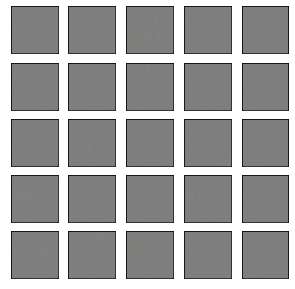

Epoch[0/100],d_loss:1.601386,g_loss:4.063254 D real: 0.516661,D fake: 0.006269
Epoch[0/100],d_loss:0.519039,g_loss:5.411576 D real: 0.765340,D fake: 0.001168
Epoch[0/100],d_loss:0.532225,g_loss:4.112446 D real: 0.709539,D fake: 0.006529
Epoch[0/100],d_loss:0.536353,g_loss:3.702280 D real: 0.761265,D fake: 0.010844


  1%|          | 1/100 [00:21<35:16, 21.38s/it]

Epoch[1/100],d_loss:0.561293,g_loss:4.700455 D real: 0.847292,D fake: 0.003243
Epoch[1/100],d_loss:0.581256,g_loss:3.580060 D real: 0.802519,D fake: 0.014509
Epoch[1/100],d_loss:0.732323,g_loss:1.951307 D real: 0.580087,D fake: 0.114196
Epoch[1/100],d_loss:0.620300,g_loss:3.064870 D real: 0.783905,D fake: 0.026404


  2%|▏         | 2/100 [00:38<32:52, 20.12s/it]

Epoch[2/100],d_loss:1.547332,g_loss:3.262855 D real: 0.202146,D fake: 0.032904
Epoch[2/100],d_loss:0.726732,g_loss:2.106789 D real: 0.655232,D fake: 0.090673
Epoch[2/100],d_loss:0.830349,g_loss:3.219886 D real: 0.775124,D fake: 0.022960
Epoch[2/100],d_loss:0.834050,g_loss:2.626940 D real: 0.680735,D fake: 0.047129


  3%|▎         | 3/100 [00:54<30:29, 18.86s/it]

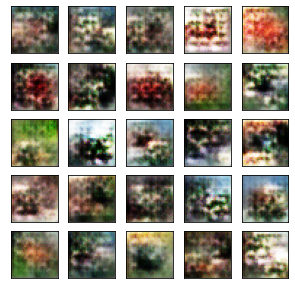

Epoch[3/100],d_loss:0.940757,g_loss:1.913913 D real: 0.441495,D fake: 0.120597
Epoch[3/100],d_loss:0.910784,g_loss:1.958620 D real: 0.569507,D fake: 0.101616
Epoch[3/100],d_loss:0.781097,g_loss:1.956379 D real: 0.624733,D fake: 0.107741
Epoch[3/100],d_loss:0.801075,g_loss:2.486609 D real: 0.657784,D fake: 0.056650


  4%|▍         | 4/100 [01:13<30:26, 19.03s/it]

Epoch[4/100],d_loss:0.874991,g_loss:2.967855 D real: 0.841631,D fake: 0.033607
Epoch[4/100],d_loss:0.965911,g_loss:3.288970 D real: 0.735769,D fake: 0.024071
Epoch[4/100],d_loss:0.797867,g_loss:1.679373 D real: 0.559270,D fake: 0.157964
Epoch[4/100],d_loss:0.771007,g_loss:2.155833 D real: 0.625388,D fake: 0.087126


  5%|▌         | 5/100 [01:32<30:02, 18.97s/it]

Epoch[5/100],d_loss:1.113843,g_loss:1.335902 D real: 0.351247,D fake: 0.237657
Epoch[5/100],d_loss:0.744558,g_loss:2.089194 D real: 0.663687,D fake: 0.089615
Epoch[5/100],d_loss:0.825853,g_loss:1.706654 D real: 0.512270,D fake: 0.154094
Epoch[5/100],d_loss:0.818237,g_loss:2.129119 D real: 0.744347,D fake: 0.090835


  6%|▌         | 6/100 [01:50<29:07, 18.59s/it]

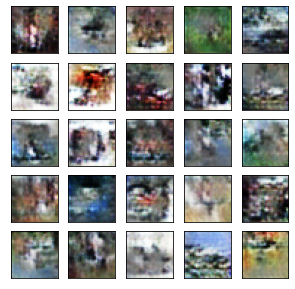

Epoch[6/100],d_loss:0.779501,g_loss:2.342671 D real: 0.657536,D fake: 0.068745
Epoch[6/100],d_loss:1.126751,g_loss:1.346185 D real: 0.354967,D fake: 0.225383
Epoch[6/100],d_loss:0.893669,g_loss:1.756811 D real: 0.621949,D fake: 0.140106
Epoch[6/100],d_loss:1.192471,g_loss:1.735729 D real: 0.299441,D fake: 0.150086


  7%|▋         | 7/100 [02:11<29:45, 19.20s/it]

Epoch[7/100],d_loss:0.855183,g_loss:2.803088 D real: 0.763201,D fake: 0.039453
Epoch[7/100],d_loss:0.889699,g_loss:2.640150 D real: 0.743951,D fake: 0.043953
Epoch[7/100],d_loss:0.888709,g_loss:1.513136 D real: 0.479964,D fake: 0.185146
Epoch[7/100],d_loss:1.118105,g_loss:1.035977 D real: 0.340051,D fake: 0.336339


  8%|▊         | 8/100 [02:28<28:38, 18.68s/it]

Epoch[8/100],d_loss:0.918498,g_loss:1.716871 D real: 0.447680,D fake: 0.146087
Epoch[8/100],d_loss:0.850406,g_loss:1.890266 D real: 0.586163,D fake: 0.115227
Epoch[8/100],d_loss:1.446353,g_loss:0.984801 D real: 0.225141,D fake: 0.368751
Epoch[8/100],d_loss:0.915603,g_loss:2.016731 D real: 0.679359,D fake: 0.097868


  9%|▉         | 9/100 [02:46<28:13, 18.61s/it]

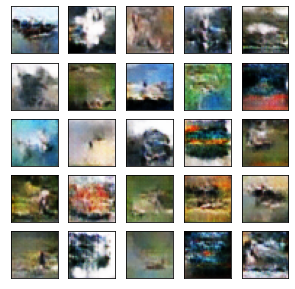

Epoch[9/100],d_loss:0.837637,g_loss:1.690186 D real: 0.573030,D fake: 0.154108
Epoch[9/100],d_loss:0.883993,g_loss:2.327481 D real: 0.736580,D fake: 0.070564
Epoch[9/100],d_loss:1.303174,g_loss:3.326770 D real: 0.837447,D fake: 0.019802
Epoch[9/100],d_loss:0.948080,g_loss:1.659242 D real: 0.629759,D fake: 0.154477


 10%|█         | 10/100 [03:05<27:48, 18.54s/it]

Epoch[10/100],d_loss:0.904429,g_loss:1.665553 D real: 0.623450,D fake: 0.159987
Epoch[10/100],d_loss:0.856291,g_loss:1.640183 D real: 0.601280,D fake: 0.158608
Epoch[10/100],d_loss:0.829849,g_loss:1.550233 D real: 0.594188,D fake: 0.177420
Epoch[10/100],d_loss:1.119252,g_loss:1.133130 D real: 0.360108,D fake: 0.293128


 11%|█         | 11/100 [03:23<27:30, 18.55s/it]

Epoch[11/100],d_loss:1.004047,g_loss:2.142224 D real: 0.735908,D fake: 0.090423
Epoch[11/100],d_loss:0.918966,g_loss:2.033321 D real: 0.588267,D fake: 0.101919
Epoch[11/100],d_loss:0.898655,g_loss:1.835921 D real: 0.614510,D fake: 0.123944
Epoch[11/100],d_loss:0.910199,g_loss:1.622642 D real: 0.588854,D fake: 0.159335


 12%|█▏        | 12/100 [03:41<26:40, 18.19s/it]

Epoch[12/100],d_loss:0.862558,g_loss:1.415340 D real: 0.633909,D fake: 0.203598
Epoch[12/100],d_loss:0.886828,g_loss:1.809845 D real: 0.563877,D fake: 0.125169
Epoch[12/100],d_loss:1.077604,g_loss:2.139765 D real: 0.651429,D fake: 0.083997
Epoch[12/100],d_loss:0.944937,g_loss:1.339441 D real: 0.507000,D fake: 0.231042


 13%|█▎        | 13/100 [04:02<27:50, 19.20s/it]

Epoch[13/100],d_loss:0.828062,g_loss:1.455535 D real: 0.641173,D fake: 0.198806
Epoch[13/100],d_loss:0.947629,g_loss:1.251053 D real: 0.478989,D fake: 0.261184
Epoch[13/100],d_loss:0.951498,g_loss:1.087254 D real: 0.469294,D fake: 0.303378
Epoch[13/100],d_loss:0.850265,g_loss:1.664468 D real: 0.668916,D fake: 0.156213


 14%|█▍        | 14/100 [04:20<26:46, 18.68s/it]

Epoch[14/100],d_loss:0.960610,g_loss:1.221913 D real: 0.441089,D fake: 0.270180
Epoch[14/100],d_loss:1.202641,g_loss:0.864685 D real: 0.319599,D fake: 0.415624
Epoch[14/100],d_loss:1.040871,g_loss:1.319510 D real: 0.422479,D fake: 0.238928
Epoch[14/100],d_loss:0.900404,g_loss:1.121832 D real: 0.487196,D fake: 0.299724


 15%|█▌        | 15/100 [04:37<25:54, 18.29s/it]

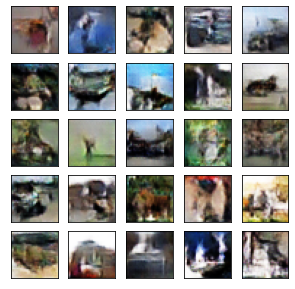

Epoch[15/100],d_loss:0.921336,g_loss:1.599610 D real: 0.543593,D fake: 0.164855
Epoch[15/100],d_loss:0.927169,g_loss:1.256583 D real: 0.629088,D fake: 0.246837
Epoch[15/100],d_loss:0.955610,g_loss:1.278913 D real: 0.527116,D fake: 0.252520
Epoch[15/100],d_loss:1.046753,g_loss:1.462047 D real: 0.588159,D fake: 0.196796


 16%|█▌        | 16/100 [04:58<26:30, 18.94s/it]

Epoch[16/100],d_loss:0.887733,g_loss:1.592481 D real: 0.647576,D fake: 0.164099
Epoch[16/100],d_loss:0.837758,g_loss:1.628274 D real: 0.630520,D fake: 0.161780
Epoch[16/100],d_loss:0.878183,g_loss:1.665612 D real: 0.673518,D fake: 0.155205
Epoch[16/100],d_loss:0.968051,g_loss:1.551531 D real: 0.554006,D fake: 0.177052


 17%|█▋        | 17/100 [05:19<27:08, 19.62s/it]

Epoch[17/100],d_loss:0.984586,g_loss:1.237054 D real: 0.465273,D fake: 0.254096
Epoch[17/100],d_loss:0.890606,g_loss:1.290691 D real: 0.558169,D fake: 0.245747
Epoch[17/100],d_loss:1.063233,g_loss:2.098079 D real: 0.683506,D fake: 0.091842
Epoch[17/100],d_loss:1.256715,g_loss:0.881557 D real: 0.281158,D fake: 0.414907


 18%|█▊        | 18/100 [05:35<25:32, 18.69s/it]

Epoch[18/100],d_loss:1.078522,g_loss:2.397287 D real: 0.743983,D fake: 0.063916
Epoch[18/100],d_loss:1.008558,g_loss:1.301224 D real: 0.529266,D fake: 0.236862
Epoch[18/100],d_loss:0.982224,g_loss:1.293008 D real: 0.431055,D fake: 0.238939
Epoch[18/100],d_loss:0.861863,g_loss:1.104614 D real: 0.607013,D fake: 0.297454


 19%|█▉        | 19/100 [05:56<25:55, 19.20s/it]

Epoch[19/100],d_loss:0.976968,g_loss:1.085550 D real: 0.467442,D fake: 0.319447
Epoch[19/100],d_loss:0.923826,g_loss:1.385720 D real: 0.522940,D fake: 0.223747
Epoch[19/100],d_loss:0.958985,g_loss:1.341211 D real: 0.466873,D fake: 0.221886
Epoch[19/100],d_loss:1.047107,g_loss:1.456981 D real: 0.591172,D fake: 0.200785


 20%|██        | 20/100 [06:15<25:36, 19.21s/it]

Epoch[20/100],d_loss:1.005303,g_loss:2.016465 D real: 0.688567,D fake: 0.103690
Epoch[20/100],d_loss:0.908289,g_loss:1.561880 D real: 0.626454,D fake: 0.170254
Epoch[20/100],d_loss:1.066891,g_loss:1.363919 D real: 0.528971,D fake: 0.218329
Epoch[20/100],d_loss:0.849982,g_loss:1.300268 D real: 0.599152,D fake: 0.241830


 21%|██        | 21/100 [06:32<24:30, 18.61s/it]

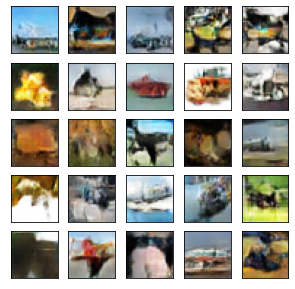

Epoch[21/100],d_loss:0.936054,g_loss:1.464902 D real: 0.493020,D fake: 0.198808
Epoch[21/100],d_loss:1.008869,g_loss:1.256191 D real: 0.427904,D fake: 0.249249
Epoch[21/100],d_loss:0.848083,g_loss:1.736979 D real: 0.578477,D fake: 0.133937
Epoch[21/100],d_loss:0.864068,g_loss:1.283646 D real: 0.636630,D fake: 0.241921


 22%|██▏       | 22/100 [06:50<23:57, 18.43s/it]

Epoch[22/100],d_loss:0.920255,g_loss:1.597850 D real: 0.542983,D fake: 0.162577
Epoch[22/100],d_loss:1.040506,g_loss:1.226975 D real: 0.457923,D fake: 0.260414
Epoch[22/100],d_loss:0.989231,g_loss:1.511305 D real: 0.626378,D fake: 0.190188
Epoch[22/100],d_loss:0.961325,g_loss:1.429735 D real: 0.540318,D fake: 0.206068


 23%|██▎       | 23/100 [07:07<23:12, 18.08s/it]

Epoch[23/100],d_loss:0.990044,g_loss:1.222085 D real: 0.454947,D fake: 0.279955
Epoch[23/100],d_loss:0.946806,g_loss:1.861129 D real: 0.668358,D fake: 0.126575
Epoch[23/100],d_loss:0.902428,g_loss:1.866036 D real: 0.641617,D fake: 0.120056
Epoch[23/100],d_loss:0.991860,g_loss:1.299624 D real: 0.519749,D fake: 0.235945


 24%|██▍       | 24/100 [07:25<22:32, 17.80s/it]

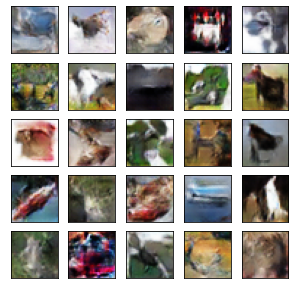

Epoch[24/100],d_loss:0.976458,g_loss:1.659688 D real: 0.647610,D fake: 0.155678
Epoch[24/100],d_loss:1.113646,g_loss:2.078753 D real: 0.679598,D fake: 0.091985
Epoch[24/100],d_loss:0.857330,g_loss:1.590153 D real: 0.557975,D fake: 0.168668
Epoch[24/100],d_loss:0.975947,g_loss:1.553571 D real: 0.619128,D fake: 0.177822


 25%|██▌       | 25/100 [07:46<23:33, 18.84s/it]

Epoch[25/100],d_loss:0.949081,g_loss:1.573009 D real: 0.651580,D fake: 0.173486
Epoch[25/100],d_loss:0.934319,g_loss:1.216403 D real: 0.575077,D fake: 0.277399
Epoch[25/100],d_loss:0.916137,g_loss:1.118538 D real: 0.498220,D fake: 0.313038
Epoch[25/100],d_loss:1.090403,g_loss:1.117070 D real: 0.387317,D fake: 0.302352


 26%|██▌       | 26/100 [08:04<23:01, 18.67s/it]

Epoch[26/100],d_loss:0.926829,g_loss:1.421540 D real: 0.683461,D fake: 0.211357
Epoch[26/100],d_loss:0.862799,g_loss:1.656985 D real: 0.600324,D fake: 0.161412
Epoch[26/100],d_loss:1.086007,g_loss:2.233476 D real: 0.762304,D fake: 0.083021
Epoch[26/100],d_loss:0.979994,g_loss:1.670511 D real: 0.649029,D fake: 0.160715


 27%|██▋       | 27/100 [08:23<22:51, 18.79s/it]

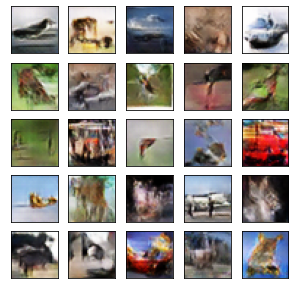

Epoch[27/100],d_loss:1.018976,g_loss:1.337711 D real: 0.401444,D fake: 0.236895
Epoch[27/100],d_loss:0.820465,g_loss:1.464107 D real: 0.594406,D fake: 0.196678
Epoch[27/100],d_loss:0.922321,g_loss:2.117376 D real: 0.712289,D fake: 0.088218
Epoch[27/100],d_loss:0.954105,g_loss:1.474603 D real: 0.561092,D fake: 0.199406


 28%|██▊       | 28/100 [08:44<23:10, 19.31s/it]

Epoch[28/100],d_loss:0.925974,g_loss:1.471427 D real: 0.533008,D fake: 0.205113
Epoch[28/100],d_loss:1.148702,g_loss:0.698207 D real: 0.363967,D fake: 0.560151
Epoch[28/100],d_loss:0.912237,g_loss:1.492870 D real: 0.500379,D fake: 0.186971
Epoch[28/100],d_loss:1.103272,g_loss:1.153715 D real: 0.372307,D fake: 0.299928


 29%|██▉       | 29/100 [09:01<21:57, 18.56s/it]

Epoch[29/100],d_loss:0.980026,g_loss:2.051395 D real: 0.713242,D fake: 0.094144
Epoch[29/100],d_loss:0.852752,g_loss:1.389657 D real: 0.564352,D fake: 0.213014
Epoch[29/100],d_loss:0.881778,g_loss:1.332968 D real: 0.542967,D fake: 0.232332
Epoch[29/100],d_loss:0.941480,g_loss:1.198660 D real: 0.477222,D fake: 0.280101


 30%|███       | 30/100 [09:19<21:26, 18.38s/it]

Epoch[30/100],d_loss:0.960695,g_loss:1.833693 D real: 0.693155,D fake: 0.125930
Epoch[30/100],d_loss:1.009632,g_loss:1.648744 D real: 0.534590,D fake: 0.168172
Epoch[30/100],d_loss:0.912089,g_loss:1.253521 D real: 0.606463,D fake: 0.255786
Epoch[30/100],d_loss:0.862278,g_loss:1.344894 D real: 0.656584,D fake: 0.225043


 31%|███       | 31/100 [09:37<21:16, 18.50s/it]

Epoch[31/100],d_loss:0.792940,g_loss:1.766267 D real: 0.679177,D fake: 0.135736
Epoch[31/100],d_loss:0.901948,g_loss:1.343366 D real: 0.583185,D fake: 0.226905
Epoch[31/100],d_loss:0.991236,g_loss:1.158866 D real: 0.438263,D fake: 0.284365
Epoch[31/100],d_loss:0.936508,g_loss:1.954358 D real: 0.633147,D fake: 0.111223


 32%|███▏      | 32/100 [09:53<20:06, 17.74s/it]

Epoch[32/100],d_loss:0.890245,g_loss:1.466287 D real: 0.536600,D fake: 0.201358
Epoch[32/100],d_loss:0.817680,g_loss:1.805419 D real: 0.624266,D fake: 0.129451
Epoch[32/100],d_loss:0.920890,g_loss:1.259095 D real: 0.583567,D fake: 0.251880
Epoch[32/100],d_loss:0.912666,g_loss:1.385041 D real: 0.479772,D fake: 0.219054


 33%|███▎      | 33/100 [10:12<19:59, 17.90s/it]

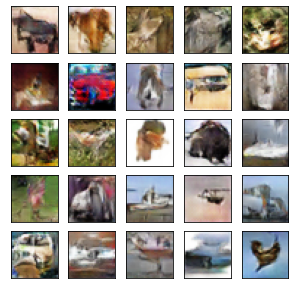

Epoch[33/100],d_loss:0.907782,g_loss:1.980404 D real: 0.748383,D fake: 0.107462
Epoch[33/100],d_loss:0.818142,g_loss:2.129357 D real: 0.649606,D fake: 0.092309
Epoch[33/100],d_loss:0.764644,g_loss:1.677701 D real: 0.673726,D fake: 0.163884
Epoch[33/100],d_loss:0.885079,g_loss:2.011943 D real: 0.765494,D fake: 0.102644


 34%|███▍      | 34/100 [10:32<20:32, 18.68s/it]

Epoch[34/100],d_loss:1.061587,g_loss:2.162724 D real: 0.718943,D fake: 0.094486
Epoch[34/100],d_loss:0.815453,g_loss:1.949287 D real: 0.702293,D fake: 0.113026
Epoch[34/100],d_loss:0.919484,g_loss:1.243247 D real: 0.509576,D fake: 0.268938
Epoch[34/100],d_loss:0.885293,g_loss:1.439941 D real: 0.642773,D fake: 0.209301


 35%|███▌      | 35/100 [10:50<20:03, 18.52s/it]

Epoch[35/100],d_loss:0.973484,g_loss:2.147123 D real: 0.745301,D fake: 0.088670
Epoch[35/100],d_loss:0.791722,g_loss:1.348077 D real: 0.577662,D fake: 0.241064
Epoch[35/100],d_loss:1.266143,g_loss:1.799366 D real: 0.654232,D fake: 0.146318
Epoch[35/100],d_loss:0.859899,g_loss:1.808082 D real: 0.636727,D fake: 0.129282


 36%|███▌      | 36/100 [11:09<19:52, 18.63s/it]

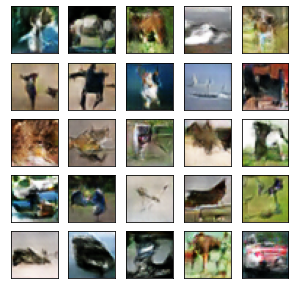

Epoch[36/100],d_loss:0.861959,g_loss:1.462153 D real: 0.568011,D fake: 0.196929
Epoch[36/100],d_loss:0.930212,g_loss:1.410643 D real: 0.471391,D fake: 0.222349
Epoch[36/100],d_loss:0.890397,g_loss:1.319091 D real: 0.569389,D fake: 0.246956
Epoch[36/100],d_loss:0.758338,g_loss:1.638780 D real: 0.602226,D fake: 0.165680


 37%|███▋      | 37/100 [11:30<20:12, 19.24s/it]

Epoch[37/100],d_loss:0.826677,g_loss:1.366254 D real: 0.546989,D fake: 0.225359
Epoch[37/100],d_loss:1.112415,g_loss:2.517050 D real: 0.795015,D fake: 0.055719
Epoch[37/100],d_loss:1.087022,g_loss:2.229893 D real: 0.814976,D fake: 0.080017
Epoch[37/100],d_loss:0.864442,g_loss:1.549104 D real: 0.670091,D fake: 0.178778


 38%|███▊      | 38/100 [11:47<19:20, 18.72s/it]

Epoch[38/100],d_loss:0.888732,g_loss:1.843873 D real: 0.599664,D fake: 0.132516
Epoch[38/100],d_loss:0.852618,g_loss:1.610105 D real: 0.577845,D fake: 0.173884
Epoch[38/100],d_loss:0.860812,g_loss:1.570799 D real: 0.578004,D fake: 0.171412
Epoch[38/100],d_loss:0.854277,g_loss:1.515031 D real: 0.604512,D fake: 0.184831


 39%|███▉      | 39/100 [12:04<18:27, 18.16s/it]

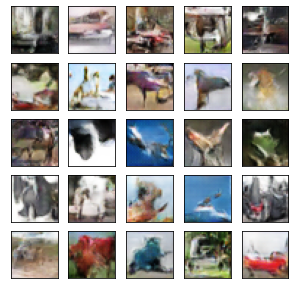

Epoch[39/100],d_loss:0.879028,g_loss:1.404715 D real: 0.510016,D fake: 0.222144
Epoch[39/100],d_loss:0.796701,g_loss:1.421134 D real: 0.558033,D fake: 0.219577
Epoch[39/100],d_loss:0.989799,g_loss:1.095722 D real: 0.464451,D fake: 0.321496
Epoch[39/100],d_loss:0.731646,g_loss:1.846703 D real: 0.714933,D fake: 0.128801


 40%|████      | 40/100 [12:25<18:58, 18.97s/it]

Epoch[40/100],d_loss:0.841802,g_loss:1.870689 D real: 0.648324,D fake: 0.131388
Epoch[40/100],d_loss:0.787161,g_loss:1.502281 D real: 0.556705,D fake: 0.199940
Epoch[40/100],d_loss:0.903896,g_loss:1.522378 D real: 0.568926,D fake: 0.199008
Epoch[40/100],d_loss:0.903363,g_loss:1.452684 D real: 0.649786,D fake: 0.211508


 41%|████      | 41/100 [12:43<18:30, 18.82s/it]

Epoch[41/100],d_loss:0.898005,g_loss:1.699293 D real: 0.592082,D fake: 0.149126
Epoch[41/100],d_loss:0.804268,g_loss:1.863702 D real: 0.614921,D fake: 0.129244
Epoch[41/100],d_loss:0.827940,g_loss:1.535896 D real: 0.570057,D fake: 0.193090
Epoch[41/100],d_loss:0.862898,g_loss:1.950999 D real: 0.777591,D fake: 0.115363


 42%|████▏     | 42/100 [13:02<18:11, 18.82s/it]

Epoch[42/100],d_loss:0.802409,g_loss:1.847433 D real: 0.653112,D fake: 0.132657
Epoch[42/100],d_loss:0.875798,g_loss:1.593329 D real: 0.562040,D fake: 0.182648
Epoch[42/100],d_loss:0.809311,g_loss:1.496261 D real: 0.590994,D fake: 0.195241
Epoch[42/100],d_loss:1.109355,g_loss:2.605690 D real: 0.706027,D fake: 0.051081


 43%|████▎     | 43/100 [13:21<17:58, 18.92s/it]

Epoch[43/100],d_loss:0.850034,g_loss:1.697320 D real: 0.697852,D fake: 0.160568
Epoch[43/100],d_loss:0.800419,g_loss:2.209779 D real: 0.685115,D fake: 0.082837
Epoch[43/100],d_loss:0.922654,g_loss:1.270301 D real: 0.459559,D fake: 0.260447
Epoch[43/100],d_loss:0.847790,g_loss:1.428372 D real: 0.545839,D fake: 0.219672


 44%|████▍     | 44/100 [13:39<17:15, 18.48s/it]

Epoch[44/100],d_loss:0.900831,g_loss:1.607527 D real: 0.514558,D fake: 0.175887
Epoch[44/100],d_loss:0.806754,g_loss:1.783916 D real: 0.565489,D fake: 0.139359
Epoch[44/100],d_loss:1.359046,g_loss:3.102863 D real: 0.887993,D fake: 0.028496
Epoch[44/100],d_loss:0.873716,g_loss:1.896409 D real: 0.627768,D fake: 0.131015


 45%|████▌     | 45/100 [13:57<16:54, 18.44s/it]

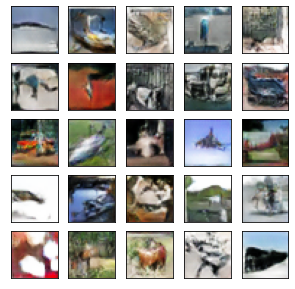

Epoch[45/100],d_loss:0.909007,g_loss:1.145133 D real: 0.456233,D fake: 0.306235
Epoch[45/100],d_loss:0.882313,g_loss:2.157122 D real: 0.761578,D fake: 0.087964
Epoch[45/100],d_loss:0.806318,g_loss:1.810032 D real: 0.688596,D fake: 0.132055
Epoch[45/100],d_loss:0.759274,g_loss:1.533385 D real: 0.634374,D fake: 0.196404


 46%|████▌     | 46/100 [14:19<17:31, 19.47s/it]

Epoch[46/100],d_loss:0.782192,g_loss:1.334471 D real: 0.608303,D fake: 0.240418
Epoch[46/100],d_loss:0.898141,g_loss:2.129025 D real: 0.710263,D fake: 0.087569
Epoch[46/100],d_loss:0.794653,g_loss:1.626364 D real: 0.564824,D fake: 0.177700
Epoch[46/100],d_loss:0.780388,g_loss:1.813098 D real: 0.657912,D fake: 0.135345


 47%|████▋     | 47/100 [14:37<16:51, 19.08s/it]

Epoch[47/100],d_loss:0.792058,g_loss:2.345986 D real: 0.727157,D fake: 0.072031
Epoch[47/100],d_loss:0.769627,g_loss:1.663628 D real: 0.557520,D fake: 0.164257
Epoch[47/100],d_loss:0.785871,g_loss:1.515137 D real: 0.638869,D fake: 0.194954
Epoch[47/100],d_loss:0.764814,g_loss:1.589872 D real: 0.608134,D fake: 0.180290


 48%|████▊     | 48/100 [14:56<16:24, 18.94s/it]

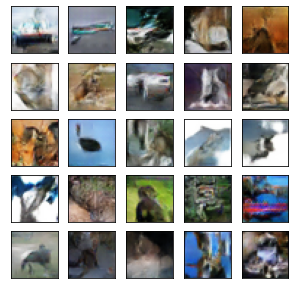

Epoch[48/100],d_loss:0.779104,g_loss:2.189444 D real: 0.540926,D fake: 0.087094
Epoch[48/100],d_loss:0.838806,g_loss:1.844617 D real: 0.656920,D fake: 0.136516
Epoch[48/100],d_loss:0.787201,g_loss:1.655492 D real: 0.640764,D fake: 0.177642
Epoch[48/100],d_loss:0.877581,g_loss:1.736450 D real: 0.625415,D fake: 0.154103


 49%|████▉     | 49/100 [15:15<16:08, 19.00s/it]

Epoch[49/100],d_loss:0.855248,g_loss:1.657075 D real: 0.674662,D fake: 0.159798
Epoch[49/100],d_loss:0.928554,g_loss:2.012947 D real: 0.628571,D fake: 0.109400
Epoch[49/100],d_loss:0.744346,g_loss:1.863308 D real: 0.625975,D fake: 0.127180
Epoch[49/100],d_loss:0.847167,g_loss:1.584381 D real: 0.510687,D fake: 0.191115


 50%|█████     | 50/100 [15:32<15:20, 18.41s/it]

Epoch[50/100],d_loss:0.922998,g_loss:1.300407 D real: 0.447969,D fake: 0.261064
Epoch[50/100],d_loss:0.749218,g_loss:1.823688 D real: 0.638730,D fake: 0.134602
Epoch[50/100],d_loss:0.871317,g_loss:1.926624 D real: 0.774014,D fake: 0.115810
Epoch[50/100],d_loss:0.800364,g_loss:1.503431 D real: 0.700105,D fake: 0.196261


 51%|█████     | 51/100 [15:48<14:25, 17.67s/it]

Epoch[51/100],d_loss:0.764655,g_loss:1.975487 D real: 0.731572,D fake: 0.114420
Epoch[51/100],d_loss:0.817660,g_loss:1.350419 D real: 0.592056,D fake: 0.243745
Epoch[51/100],d_loss:0.727601,g_loss:1.889382 D real: 0.626733,D fake: 0.125785
Epoch[51/100],d_loss:0.786417,g_loss:2.251520 D real: 0.621523,D fake: 0.083336


 52%|█████▏    | 52/100 [16:10<15:17, 19.11s/it]

Epoch[52/100],d_loss:0.819286,g_loss:1.396393 D real: 0.576947,D fake: 0.224205
Epoch[52/100],d_loss:0.823978,g_loss:1.919018 D real: 0.543421,D fake: 0.123606
Epoch[52/100],d_loss:0.719886,g_loss:1.806829 D real: 0.636365,D fake: 0.153854
Epoch[52/100],d_loss:0.806603,g_loss:2.094793 D real: 0.635337,D fake: 0.099187


 53%|█████▎    | 53/100 [16:29<14:47, 18.89s/it]

Epoch[53/100],d_loss:0.773796,g_loss:1.907925 D real: 0.710672,D fake: 0.125497
Epoch[53/100],d_loss:0.902612,g_loss:1.821367 D real: 0.527989,D fake: 0.141544
Epoch[53/100],d_loss:0.729912,g_loss:1.676249 D real: 0.633626,D fake: 0.158742
Epoch[53/100],d_loss:0.816056,g_loss:2.139396 D real: 0.739533,D fake: 0.097768


 54%|█████▍    | 54/100 [16:45<13:57, 18.21s/it]

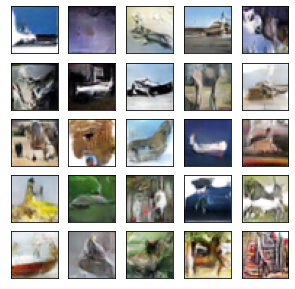

Epoch[54/100],d_loss:0.777008,g_loss:1.731551 D real: 0.594587,D fake: 0.147350
Epoch[54/100],d_loss:0.770243,g_loss:1.792009 D real: 0.670572,D fake: 0.147849
Epoch[54/100],d_loss:0.733036,g_loss:2.284617 D real: 0.699075,D fake: 0.080217
Epoch[54/100],d_loss:0.775677,g_loss:1.929688 D real: 0.631093,D fake: 0.124772


 55%|█████▌    | 55/100 [17:03<13:32, 18.06s/it]

Epoch[55/100],d_loss:0.831275,g_loss:1.659066 D real: 0.489058,D fake: 0.181263
Epoch[55/100],d_loss:0.819132,g_loss:2.060839 D real: 0.488071,D fake: 0.107029
Epoch[55/100],d_loss:0.844419,g_loss:2.065441 D real: 0.808600,D fake: 0.102731
Epoch[55/100],d_loss:0.787916,g_loss:2.072227 D real: 0.757867,D fake: 0.105040


 56%|█████▌    | 56/100 [17:21<13:09, 17.95s/it]

Epoch[56/100],d_loss:0.908197,g_loss:2.230193 D real: 0.788346,D fake: 0.088440
Epoch[56/100],d_loss:0.767576,g_loss:1.767238 D real: 0.576773,D fake: 0.155266
Epoch[56/100],d_loss:0.832802,g_loss:1.873752 D real: 0.800875,D fake: 0.132003
Epoch[56/100],d_loss:0.700548,g_loss:1.951015 D real: 0.653964,D fake: 0.117166


 57%|█████▋    | 57/100 [17:39<12:48, 17.87s/it]

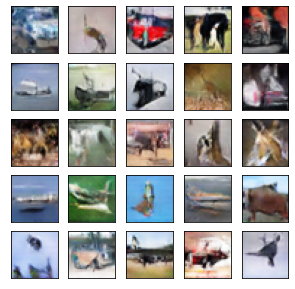

Epoch[57/100],d_loss:0.755760,g_loss:2.095753 D real: 0.629373,D fake: 0.101829
Epoch[57/100],d_loss:0.791159,g_loss:1.433080 D real: 0.547350,D fake: 0.224320
Epoch[57/100],d_loss:0.729822,g_loss:2.141621 D real: 0.593390,D fake: 0.097683
Epoch[57/100],d_loss:0.810812,g_loss:2.778295 D real: 0.838346,D fake: 0.046097


 58%|█████▊    | 58/100 [17:56<12:26, 17.77s/it]

Epoch[58/100],d_loss:0.804600,g_loss:1.844445 D real: 0.557156,D fake: 0.135372
Epoch[58/100],d_loss:0.845341,g_loss:1.720096 D real: 0.519994,D fake: 0.150220
Epoch[58/100],d_loss:0.996825,g_loss:1.203147 D real: 0.459191,D fake: 0.309119
Epoch[58/100],d_loss:0.844248,g_loss:1.648674 D real: 0.530563,D fake: 0.177011


 59%|█████▉    | 59/100 [18:13<12:04, 17.66s/it]

Epoch[59/100],d_loss:0.816098,g_loss:2.136466 D real: 0.743136,D fake: 0.106594
Epoch[59/100],d_loss:0.743397,g_loss:2.035187 D real: 0.738361,D fake: 0.107225
Epoch[59/100],d_loss:0.799528,g_loss:1.518577 D real: 0.572992,D fake: 0.214719
Epoch[59/100],d_loss:0.964956,g_loss:1.103493 D real: 0.429774,D fake: 0.319644


 60%|██████    | 60/100 [18:29<11:24, 17.12s/it]

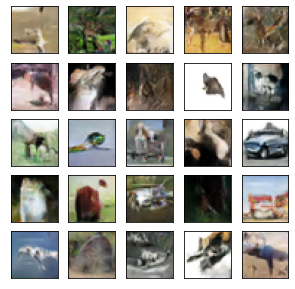

Epoch[60/100],d_loss:0.714903,g_loss:1.961623 D real: 0.795739,D fake: 0.116010
Epoch[60/100],d_loss:0.748403,g_loss:2.333904 D real: 0.711185,D fake: 0.078131
Epoch[60/100],d_loss:0.742293,g_loss:1.607924 D real: 0.640449,D fake: 0.177683
Epoch[60/100],d_loss:0.807543,g_loss:1.907969 D real: 0.588910,D fake: 0.137755


 61%|██████    | 61/100 [18:49<11:31, 17.74s/it]

Epoch[61/100],d_loss:1.131896,g_loss:1.352861 D real: 0.319534,D fake: 0.259728
Epoch[61/100],d_loss:0.732756,g_loss:2.340922 D real: 0.715896,D fake: 0.075555
Epoch[61/100],d_loss:0.724279,g_loss:1.999949 D real: 0.631765,D fake: 0.113545
Epoch[61/100],d_loss:0.836342,g_loss:1.568189 D real: 0.512364,D fake: 0.196166


 62%|██████▏   | 62/100 [19:02<10:27, 16.51s/it]

Epoch[62/100],d_loss:0.694176,g_loss:1.966731 D real: 0.686537,D fake: 0.115997
Epoch[62/100],d_loss:0.742751,g_loss:1.999308 D real: 0.604111,D fake: 0.119846
Epoch[62/100],d_loss:0.787868,g_loss:1.848404 D real: 0.725284,D fake: 0.145663
Epoch[62/100],d_loss:0.817601,g_loss:1.272710 D real: 0.504183,D fake: 0.270334


 63%|██████▎   | 63/100 [19:17<09:48, 15.91s/it]

Epoch[63/100],d_loss:0.716652,g_loss:2.068471 D real: 0.670095,D fake: 0.104459
Epoch[63/100],d_loss:0.716865,g_loss:1.850071 D real: 0.655067,D fake: 0.139433
Epoch[63/100],d_loss:0.747950,g_loss:2.057855 D real: 0.632810,D fake: 0.099377
Epoch[63/100],d_loss:0.673328,g_loss:2.022106 D real: 0.651187,D fake: 0.115660


 64%|██████▍   | 64/100 [19:37<10:15, 17.10s/it]

Epoch[64/100],d_loss:0.712304,g_loss:1.842299 D real: 0.626840,D fake: 0.139573
Epoch[64/100],d_loss:0.737349,g_loss:2.687251 D real: 0.778270,D fake: 0.049806
Epoch[64/100],d_loss:0.735295,g_loss:1.985181 D real: 0.658715,D fake: 0.117567
Epoch[64/100],d_loss:0.755421,g_loss:1.614094 D real: 0.679586,D fake: 0.173313


 65%|██████▌   | 65/100 [19:55<10:14, 17.55s/it]

Epoch[65/100],d_loss:0.734692,g_loss:1.735801 D real: 0.621177,D fake: 0.163852
Epoch[65/100],d_loss:0.715074,g_loss:2.298379 D real: 0.769031,D fake: 0.083686
Epoch[65/100],d_loss:0.744274,g_loss:1.867232 D real: 0.662838,D fake: 0.129088
Epoch[65/100],d_loss:1.072459,g_loss:2.528503 D real: 0.661699,D fake: 0.072168


 66%|██████▌   | 66/100 [20:14<10:10, 17.95s/it]

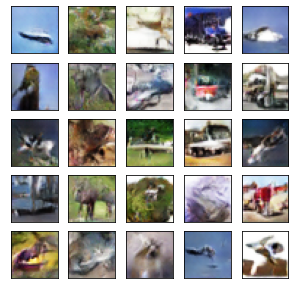

Epoch[66/100],d_loss:0.796234,g_loss:1.605103 D real: 0.534461,D fake: 0.185975
Epoch[66/100],d_loss:0.836372,g_loss:2.084416 D real: 0.774697,D fake: 0.102001
Epoch[66/100],d_loss:0.681334,g_loss:2.631153 D real: 0.769223,D fake: 0.055941
Epoch[66/100],d_loss:0.921448,g_loss:1.461690 D real: 0.425970,D fake: 0.212145


 67%|██████▋   | 67/100 [20:34<10:11, 18.52s/it]

Epoch[67/100],d_loss:0.798270,g_loss:2.658962 D real: 0.842975,D fake: 0.050443
Epoch[67/100],d_loss:0.677708,g_loss:2.121735 D real: 0.665076,D fake: 0.100045
Epoch[67/100],d_loss:0.794892,g_loss:1.660644 D real: 0.519001,D fake: 0.181511
Epoch[67/100],d_loss:0.704126,g_loss:2.018787 D real: 0.619811,D fake: 0.106350


 68%|██████▊   | 68/100 [20:51<09:36, 18.02s/it]

Epoch[68/100],d_loss:0.772902,g_loss:1.994847 D real: 0.594297,D fake: 0.112276
Epoch[68/100],d_loss:1.080151,g_loss:1.124408 D real: 0.400506,D fake: 0.335142
Epoch[68/100],d_loss:0.754936,g_loss:1.808593 D real: 0.710350,D fake: 0.146487
Epoch[68/100],d_loss:0.823128,g_loss:1.768812 D real: 0.492499,D fake: 0.161358


 69%|██████▉   | 69/100 [21:10<09:26, 18.26s/it]

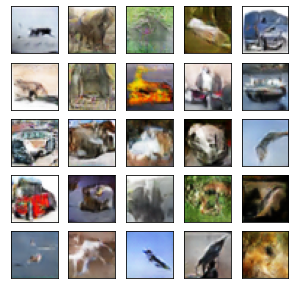

Epoch[69/100],d_loss:0.715990,g_loss:2.242964 D real: 0.775364,D fake: 0.083137
Epoch[69/100],d_loss:0.756417,g_loss:1.579596 D real: 0.683655,D fake: 0.195449
Epoch[69/100],d_loss:0.750572,g_loss:1.828983 D real: 0.760579,D fake: 0.141619
Epoch[69/100],d_loss:0.805332,g_loss:1.318871 D real: 0.558523,D fake: 0.255373


 70%|███████   | 70/100 [21:30<09:27, 18.93s/it]

Epoch[70/100],d_loss:5.180744,g_loss:0.769631 D real: 0.006307,D fake: 0.638695
Epoch[70/100],d_loss:0.677119,g_loss:2.104903 D real: 0.675225,D fake: 0.112309
Epoch[70/100],d_loss:0.730637,g_loss:2.195910 D real: 0.724278,D fake: 0.094238
Epoch[70/100],d_loss:0.738366,g_loss:1.567415 D real: 0.576186,D fake: 0.196666


 71%|███████   | 71/100 [21:49<09:05, 18.80s/it]

Epoch[71/100],d_loss:0.727485,g_loss:2.006887 D real: 0.649355,D fake: 0.115996
Epoch[71/100],d_loss:0.793441,g_loss:1.549461 D real: 0.538013,D fake: 0.219756
Epoch[71/100],d_loss:0.810270,g_loss:2.195519 D real: 0.792677,D fake: 0.098188
Epoch[71/100],d_loss:0.747119,g_loss:2.171610 D real: 0.776150,D fake: 0.100005


 72%|███████▏  | 72/100 [22:07<08:40, 18.59s/it]

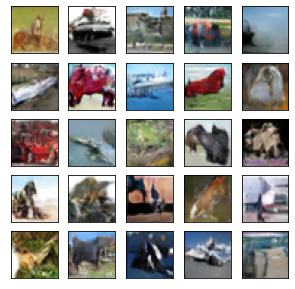

Epoch[72/100],d_loss:0.701082,g_loss:2.180798 D real: 0.728677,D fake: 0.105467
Epoch[72/100],d_loss:0.806553,g_loss:2.120023 D real: 0.805302,D fake: 0.098047
Epoch[72/100],d_loss:0.857261,g_loss:1.722824 D real: 0.498728,D fake: 0.156358
Epoch[72/100],d_loss:0.847443,g_loss:2.368586 D real: 0.800168,D fake: 0.072497


 73%|███████▎  | 73/100 [22:27<08:40, 19.26s/it]

Epoch[73/100],d_loss:0.724085,g_loss:1.848852 D real: 0.646368,D fake: 0.139339
Epoch[73/100],d_loss:0.908351,g_loss:1.481315 D real: 0.420690,D fake: 0.225657
Epoch[73/100],d_loss:0.714251,g_loss:2.058812 D real: 0.779967,D fake: 0.103221
Epoch[73/100],d_loss:0.868653,g_loss:1.769888 D real: 0.758949,D fake: 0.155960


 74%|███████▍  | 74/100 [22:45<08:08, 18.79s/it]

Epoch[74/100],d_loss:0.833024,g_loss:2.688253 D real: 0.778804,D fake: 0.054661
Epoch[74/100],d_loss:0.665134,g_loss:2.545993 D real: 0.760601,D fake: 0.058847
Epoch[74/100],d_loss:0.825904,g_loss:2.298711 D real: 0.838863,D fake: 0.081108
Epoch[74/100],d_loss:0.706441,g_loss:1.921157 D real: 0.715384,D fake: 0.126713


 75%|███████▌  | 75/100 [23:04<07:46, 18.66s/it]

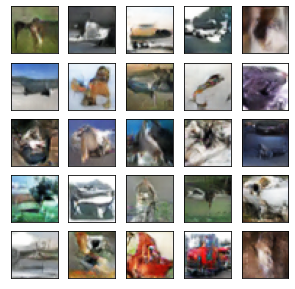

Epoch[75/100],d_loss:0.768565,g_loss:2.595976 D real: 0.783772,D fake: 0.057789
Epoch[75/100],d_loss:0.757604,g_loss:2.716097 D real: 0.769510,D fake: 0.053669
Epoch[75/100],d_loss:0.790039,g_loss:2.053559 D real: 0.683928,D fake: 0.124546
Epoch[75/100],d_loss:0.759000,g_loss:1.889988 D real: 0.612746,D fake: 0.132653


 76%|███████▌  | 76/100 [23:22<07:29, 18.73s/it]

Epoch[76/100],d_loss:0.735368,g_loss:2.088928 D real: 0.792398,D fake: 0.100837
Epoch[76/100],d_loss:0.679725,g_loss:2.082211 D real: 0.666075,D fake: 0.105115
Epoch[76/100],d_loss:0.939366,g_loss:2.769243 D real: 0.885583,D fake: 0.043095
Epoch[76/100],d_loss:0.711645,g_loss:2.133627 D real: 0.795478,D fake: 0.101936


 77%|███████▋  | 77/100 [23:41<07:11, 18.75s/it]

Epoch[77/100],d_loss:0.805111,g_loss:1.938485 D real: 0.644546,D fake: 0.138529
Epoch[77/100],d_loss:0.813183,g_loss:2.265742 D real: 0.514583,D fake: 0.086768
Epoch[77/100],d_loss:0.691606,g_loss:2.053551 D real: 0.689172,D fake: 0.109115
Epoch[77/100],d_loss:0.714723,g_loss:1.633761 D real: 0.754452,D fake: 0.187495


 78%|███████▊  | 78/100 [24:01<06:56, 18.94s/it]

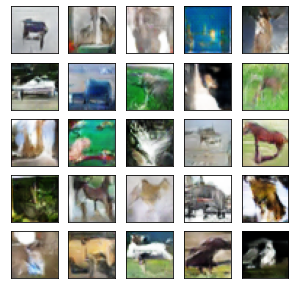

Epoch[78/100],d_loss:0.743737,g_loss:2.318399 D real: 0.806771,D fake: 0.081664
Epoch[78/100],d_loss:0.743194,g_loss:1.571433 D real: 0.593194,D fake: 0.194531
Epoch[78/100],d_loss:0.691665,g_loss:2.757023 D real: 0.742692,D fake: 0.048806
Epoch[78/100],d_loss:0.796299,g_loss:2.056061 D real: 0.695642,D fake: 0.118640


 79%|███████▉  | 79/100 [24:23<07:01, 20.05s/it]

Epoch[79/100],d_loss:0.696100,g_loss:1.961984 D real: 0.752894,D fake: 0.119419
Epoch[79/100],d_loss:0.687442,g_loss:2.199401 D real: 0.636726,D fake: 0.086925
Epoch[79/100],d_loss:0.666526,g_loss:2.062291 D real: 0.665840,D fake: 0.110523
Epoch[79/100],d_loss:0.780641,g_loss:2.202394 D real: 0.636206,D fake: 0.099417


 80%|████████  | 80/100 [24:43<06:36, 19.83s/it]

Epoch[80/100],d_loss:0.790533,g_loss:1.500937 D real: 0.527623,D fake: 0.234217
Epoch[80/100],d_loss:0.734956,g_loss:1.931959 D real: 0.745937,D fake: 0.126905
Epoch[80/100],d_loss:0.775216,g_loss:1.700156 D real: 0.628027,D fake: 0.165404
Epoch[80/100],d_loss:0.732634,g_loss:2.196405 D real: 0.714822,D fake: 0.090884


 81%|████████  | 81/100 [25:02<06:14, 19.70s/it]

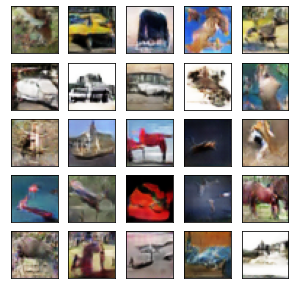

Epoch[81/100],d_loss:0.761370,g_loss:1.472484 D real: 0.574842,D fake: 0.228066
Epoch[81/100],d_loss:0.771406,g_loss:1.615043 D real: 0.569147,D fake: 0.187260
Epoch[81/100],d_loss:0.749437,g_loss:1.792218 D real: 0.693385,D fake: 0.154070
Epoch[81/100],d_loss:0.666076,g_loss:2.636567 D real: 0.740594,D fake: 0.061763


 82%|████████▏ | 82/100 [25:22<05:57, 19.83s/it]

Epoch[82/100],d_loss:0.808675,g_loss:2.678117 D real: 0.811725,D fake: 0.054138
Epoch[82/100],d_loss:1.184880,g_loss:0.923899 D real: 0.294546,D fake: 0.433491
Epoch[82/100],d_loss:0.713984,g_loss:2.423526 D real: 0.666407,D fake: 0.080835
Epoch[82/100],d_loss:0.851058,g_loss:1.357582 D real: 0.502605,D fake: 0.250033


 83%|████████▎ | 83/100 [25:41<05:32, 19.55s/it]

Epoch[83/100],d_loss:0.663435,g_loss:2.792637 D real: 0.817574,D fake: 0.049194
Epoch[83/100],d_loss:0.686566,g_loss:2.681523 D real: 0.621169,D fake: 0.059946
Epoch[83/100],d_loss:0.816678,g_loss:2.462106 D real: 0.781206,D fake: 0.070357
Epoch[83/100],d_loss:0.642964,g_loss:2.678310 D real: 0.848243,D fake: 0.050765


 84%|████████▍ | 84/100 [26:00<05:08, 19.25s/it]

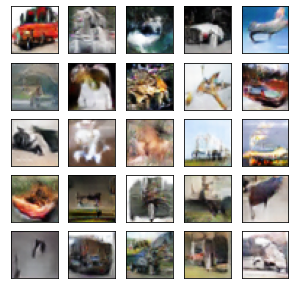

Epoch[84/100],d_loss:0.736852,g_loss:1.749609 D real: 0.641041,D fake: 0.170050
Epoch[84/100],d_loss:0.756487,g_loss:2.460137 D real: 0.825680,D fake: 0.071930
Epoch[84/100],d_loss:0.705871,g_loss:2.038485 D real: 0.697522,D fake: 0.112487
Epoch[84/100],d_loss:3.877496,g_loss:1.329194 D real: 0.148170,D fake: 0.331651


 85%|████████▌ | 85/100 [26:21<04:58, 19.93s/it]

Epoch[85/100],d_loss:0.777245,g_loss:1.877644 D real: 0.527324,D fake: 0.138617
Epoch[85/100],d_loss:0.734556,g_loss:1.719851 D real: 0.585990,D fake: 0.162052
Epoch[85/100],d_loss:0.682001,g_loss:2.393852 D real: 0.650479,D fake: 0.075228
Epoch[85/100],d_loss:0.721515,g_loss:1.738125 D real: 0.661868,D fake: 0.163808


 86%|████████▌ | 86/100 [26:39<04:32, 19.45s/it]

Epoch[86/100],d_loss:0.657746,g_loss:2.188546 D real: 0.711748,D fake: 0.094155
Epoch[86/100],d_loss:0.693922,g_loss:2.004807 D real: 0.660934,D fake: 0.114297
Epoch[86/100],d_loss:0.675615,g_loss:1.638214 D real: 0.668859,D fake: 0.178750
Epoch[86/100],d_loss:0.711019,g_loss:1.581813 D real: 0.617033,D fake: 0.200754


 87%|████████▋ | 87/100 [26:57<04:04, 18.79s/it]

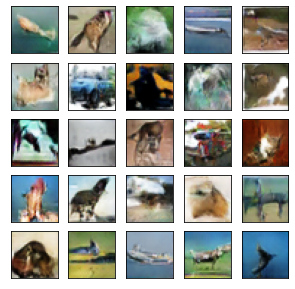

Epoch[87/100],d_loss:0.644804,g_loss:2.299319 D real: 0.792055,D fake: 0.086407
Epoch[87/100],d_loss:0.691573,g_loss:2.523549 D real: 0.732759,D fake: 0.060025
Epoch[87/100],d_loss:0.676515,g_loss:2.113021 D real: 0.612144,D fake: 0.104246
Epoch[87/100],d_loss:0.942861,g_loss:1.747049 D real: 0.405639,D fake: 0.177779


 88%|████████▊ | 88/100 [27:17<03:53, 19.42s/it]

Epoch[88/100],d_loss:1.023915,g_loss:1.414311 D real: 0.382409,D fake: 0.233317
Epoch[88/100],d_loss:0.727726,g_loss:2.371773 D real: 0.633687,D fake: 0.079342
Epoch[88/100],d_loss:0.689168,g_loss:2.453956 D real: 0.780178,D fake: 0.074097
Epoch[88/100],d_loss:1.050641,g_loss:2.050498 D real: 0.553346,D fake: 0.119549


 89%|████████▉ | 89/100 [27:36<03:30, 19.15s/it]

Epoch[89/100],d_loss:0.859731,g_loss:2.487990 D real: 0.827994,D fake: 0.065820
Epoch[89/100],d_loss:0.800659,g_loss:1.988986 D real: 0.514612,D fake: 0.129034
Epoch[89/100],d_loss:0.736754,g_loss:2.287708 D real: 0.763364,D fake: 0.091301
Epoch[89/100],d_loss:0.671248,g_loss:2.584353 D real: 0.691620,D fake: 0.065579


 90%|█████████ | 90/100 [27:53<03:04, 18.49s/it]

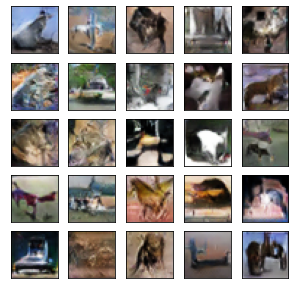

Epoch[90/100],d_loss:0.888831,g_loss:2.953547 D real: 0.883417,D fake: 0.039878
Epoch[90/100],d_loss:0.748576,g_loss:2.611660 D real: 0.773486,D fake: 0.056706
Epoch[90/100],d_loss:0.715927,g_loss:2.094261 D real: 0.628645,D fake: 0.105559
Epoch[90/100],d_loss:1.138942,g_loss:1.605540 D real: 0.332950,D fake: 0.199651


 91%|█████████ | 91/100 [28:12<02:48, 18.76s/it]

Epoch[91/100],d_loss:0.765807,g_loss:2.391973 D real: 0.797523,D fake: 0.074617
Epoch[91/100],d_loss:0.693145,g_loss:2.533313 D real: 0.602103,D fake: 0.064392
Epoch[91/100],d_loss:1.323803,g_loss:2.455400 D real: 0.581873,D fake: 0.094236
Epoch[91/100],d_loss:0.741815,g_loss:1.796988 D real: 0.632773,D fake: 0.155852


 92%|█████████▏| 92/100 [28:31<02:30, 18.78s/it]

Epoch[92/100],d_loss:0.644479,g_loss:1.902517 D real: 0.736943,D fake: 0.139057
Epoch[92/100],d_loss:0.651905,g_loss:2.116817 D real: 0.740258,D fake: 0.107956
Epoch[92/100],d_loss:0.644588,g_loss:2.249833 D real: 0.776817,D fake: 0.090680
Epoch[92/100],d_loss:0.808288,g_loss:2.297230 D real: 0.770272,D fake: 0.085433


 93%|█████████▎| 93/100 [28:49<02:09, 18.48s/it]

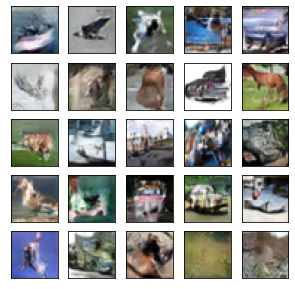

Epoch[93/100],d_loss:0.680318,g_loss:1.911712 D real: 0.751800,D fake: 0.132335
Epoch[93/100],d_loss:0.698828,g_loss:1.816291 D real: 0.718828,D fake: 0.149747
Epoch[93/100],d_loss:0.686259,g_loss:2.605135 D real: 0.733783,D fake: 0.060835
Epoch[93/100],d_loss:0.697615,g_loss:2.088529 D real: 0.682624,D fake: 0.109313


 94%|█████████▍| 94/100 [29:10<01:55, 19.21s/it]

Epoch[94/100],d_loss:0.733865,g_loss:2.210627 D real: 0.797298,D fake: 0.095127
Epoch[94/100],d_loss:0.687797,g_loss:2.165698 D real: 0.674884,D fake: 0.100097
Epoch[94/100],d_loss:0.668983,g_loss:2.216197 D real: 0.683468,D fake: 0.084578
Epoch[94/100],d_loss:0.686279,g_loss:1.912072 D real: 0.718786,D fake: 0.122582


 95%|█████████▌| 95/100 [29:28<01:34, 18.99s/it]

Epoch[95/100],d_loss:0.660906,g_loss:2.691644 D real: 0.693435,D fake: 0.052113
Epoch[95/100],d_loss:0.770487,g_loss:2.762184 D real: 0.842554,D fake: 0.048781
Epoch[95/100],d_loss:0.751531,g_loss:2.071321 D real: 0.746617,D fake: 0.112095
Epoch[95/100],d_loss:0.765576,g_loss:2.937631 D real: 0.880128,D fake: 0.037576


 96%|█████████▌| 96/100 [29:47<01:15, 18.99s/it]

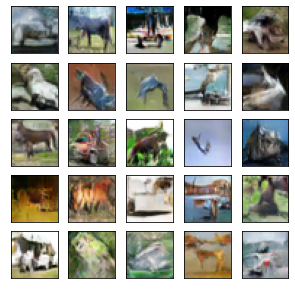

Epoch[96/100],d_loss:0.848943,g_loss:3.220417 D real: 0.882484,D fake: 0.028074
Epoch[96/100],d_loss:0.673037,g_loss:2.614841 D real: 0.730895,D fake: 0.060924
Epoch[96/100],d_loss:0.937430,g_loss:1.248410 D real: 0.417164,D fake: 0.298335
Epoch[96/100],d_loss:0.907940,g_loss:1.814462 D real: 0.463773,D fake: 0.149666


 97%|█████████▋| 97/100 [30:08<00:58, 19.54s/it]

Epoch[97/100],d_loss:0.640889,g_loss:2.427260 D real: 0.754448,D fake: 0.073341
Epoch[97/100],d_loss:0.793995,g_loss:2.157412 D real: 0.502229,D fake: 0.095790
Epoch[97/100],d_loss:0.650969,g_loss:2.384073 D real: 0.752750,D fake: 0.070849
Epoch[97/100],d_loss:0.733460,g_loss:2.442321 D real: 0.788393,D fake: 0.071464


 98%|█████████▊| 98/100 [30:27<00:38, 19.30s/it]

Epoch[98/100],d_loss:0.780948,g_loss:2.729541 D real: 0.878753,D fake: 0.056008
Epoch[98/100],d_loss:0.712585,g_loss:2.289753 D real: 0.635654,D fake: 0.088425
Epoch[98/100],d_loss:0.681989,g_loss:2.903018 D real: 0.842700,D fake: 0.040452
Epoch[98/100],d_loss:0.633850,g_loss:2.394212 D real: 0.691784,D fake: 0.076073


 99%|█████████▉| 99/100 [30:46<00:19, 19.38s/it]

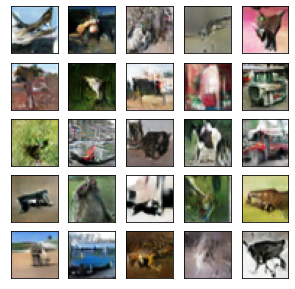

Epoch[99/100],d_loss:0.760959,g_loss:1.772970 D real: 0.530102,D fake: 0.166825
Epoch[99/100],d_loss:0.785197,g_loss:1.701398 D real: 0.567624,D fake: 0.157148
Epoch[99/100],d_loss:0.669723,g_loss:2.536997 D real: 0.693518,D fake: 0.063538
Epoch[99/100],d_loss:0.713148,g_loss:2.710735 D real: 0.798271,D fake: 0.054230


100%|██████████| 100/100 [31:07<00:00, 18.68s/it]


"    if epoch == 0:\n        real_images = inv_normalize(real_img.cpu().data)\n        save_image(real_images, '../../img/real_images.png')\n \n    fake_images = inv_normalize(fake_img.cpu().data)\n    save_image(fake_images, '../../img/fake_images-{}.png'.format(epoch+1))"

In [10]:
G_losses = []
D_losses = []

for epoch in tqdm(range(num_epoch)):
    if epoch % 3 == 0:
        G.eval()
        z = torch.randn(25, z_dim,1,1).to(device)
        img = G(z)
        plt.close()
        grid_size, k = int(img.shape[0] ** 0.5), 0 # 10 * 10
        fig, ax = plt.subplots(grid_size, grid_size, figsize=(5, 5))
        for i, j in product(range(grid_size), range(grid_size)): # to draw 10 * 10 images
            ax[i,j].get_xaxis().set_visible(False)
            ax[i,j].get_yaxis().set_visible(False)
            ax[i,j].imshow((inv_normalize(img[k]) * 255).data.cpu().numpy().transpose((1,2,0)).astype(np.uint8))
            k += 1
        plt.show()
    for i, (img, _) in enumerate(dataloader): # Since we don't need any labels, we make label be '_'

        # =============================== IMAGES =================================
        num_img = img.size(0) 
        #img = img.view(num_img, -1) # view()函数作用是将一个多行的Tensor,拼接成一行
                                    # 第一个参数是要拼接的tensor,第二个参数是-1
        # After view(), the input image will be a vector as 28 * 28 = 782 dimensions
        real_img = img.to(device) # the sampled data are real images
        # =============================== LABELS =================================
        real_label = (torch.ones(num_img) - softlabel).view(-1, 1).to(device) # Label of real images is 1
        fake_label = torch.zeros(num_img).view(-1, 1).to(device) # label of real images is 0

        # ========================= D: Forward and Loss ==========================
        
        real_out = D(real_img).view(-1,1)
        d_loss_real = criterion(real_out, real_label) 
        
        z = torch.randn(num_img, z_dim, 1, 1).to(device)
        #z = torch.randn(num_img, z_dim, 1, 1)
        
        fake_img = G(z)
        fake_out = D(fake_img).view(-1,1)
        d_loss_fake = criterion(fake_out, fake_label)
        
        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad() # before back propagation
        d_loss.backward()
        d_optimizer.step()
        D_losses.append(d_loss)
        # =============== G ========================
        # To fool the Discriminator, we want G's fake output can get 'real' pridection
        z = torch.randn(num_img, z_dim, 1, 1).to(device)
        # z = torch.randn(num_img, z_dim, 1, 1)
        
        fake_img = G(z)
        fake_out = D(fake_img).view(-1,1)
        g_loss = criterion(fake_out, real_label)
        
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        G_losses.append(g_loss)
        # ============= Visualization ===============
        if i%100 == 0:
            print('Epoch[{}/{}],d_loss:{:.6f},g_loss:{:.6f} '
                  'D real: {:.6f},D fake: {:.6f}'.format(
                epoch,num_epoch,d_loss.item(),g_loss.item(),
                real_out.data.mean(),fake_out.data.mean()  #打印的是真实图片的损失均值
            ))
        
'''    if epoch == 0:
        real_images = inv_normalize(real_img.cpu().data)
        save_image(real_images, '../../img/real_images.png')
 
    fake_images = inv_normalize(fake_img.cpu().data)
    save_image(fake_images, '../../img/fake_images-{}.png'.format(epoch+1))'''

# Visualization

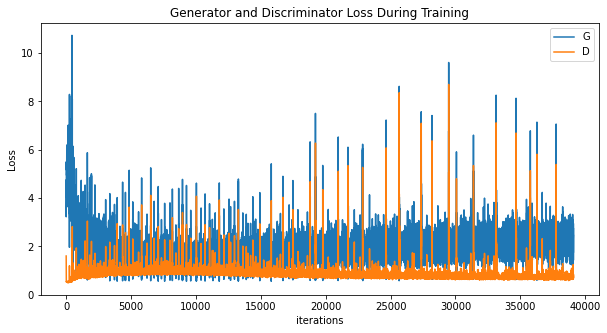

In [11]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Debug 专区

In [12]:
fake_img.shape

torch.Size([80, 3, 32, 32])

In [13]:
temp = nn.Sequential(
            nn.ConvTranspose2d(z_dim, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 5, 1, 0, bias=False),
            #nn.ConvTranspose2d(ngf * 4, ngf * 2, 5, 1, 0, bias=False)
            )

z = torch.randn(2, z_dim, 1, 1)
temp(z).shape

torch.Size([2, 256, 8, 8])